## 22230343 - Ho Li Ming

### Chest X-Ray Pneumonia Classification

### Goal:
Train a deep learning model to classify chest X-ray images as Normal or Pneumonia.

### Dataset:

This dataset contains 5,863 chest X-ray images in JPEG format from pediatric patients agedone to five years, sourced from Guangzhou Women and Children's Medical Center, organized into two categories: Pneumonia and Normal. The images are divided into training, validation, and test sets, designed for developing machine learning models to automatically detect pneumonia from chest radiography images.

### Baseline Requirements
Develop a deep learning model that can automatically classify and detect pneumonia cases from chest X-ray images, distinguishing between two categories: Normal and Pneumonia. Build and train a CNN (e.g., ResNet18 or VGG16) for classification.

### Creativity Requirement:

Implement two additional creative functions beyond the baseline.

## Step 1- Find the path to access the datasets

Copy the datasets from Kagglehub using provided path

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

### Step 2 - Setup and Imports

In [13]:
import torch
## torch neutral network modules
import torch.nn as nn
# optimization module
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
# for displaying progress bars
from tqdm import tqdm
# cinit-learn's metrics module for machine learning
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# a statistical data visualization
import seaborn as sns

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure reproducibility, same bias and weights
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda:0


### Step3 - Data Loading and Preprocessing

- Load the data from Kaggle
- Apply transformations to the images for data augmentation and normalization for better training performance

In [31]:
# Define data directories
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Image transformations, ensure the image can be trained using ResNet and increase accuracy
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_transforms['val']),
    'test': datasets.ImageFolder(TEST_DIR, data_transforms['test']),
}

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")
print(f"Classes: {class_names}")
print(f"Class to index mapping: {image_datasets['train'].class_to_idx}")

# Check class distribution (important for imbalanced datasets)
train_labels = [label for _, label in image_datasets['train']]
val_labels = [label for _, label in image_datasets['val']]
test_labels = [label for _, label in image_datasets['test']]

print("\nTrain Class Distribution:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {train_labels.count(i)} samples")

print("\nValidation Class Distribution:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {val_labels.count(i)} samples")

print("\nTest Class Distribution:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {test_labels.count(i)} samples")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624
Classes: ['NORMAL', 'PNEUMONIA']
Class to index mapping: {'NORMAL': 0, 'PNEUMONIA': 1}

Train Class Distribution:
  NORMAL: 1341 samples
  PNEUMONIA: 3875 samples

Validation Class Distribution:
  NORMAL: 8 samples
  PNEUMONIA: 8 samples

Test Class Distribution:
  NORMAL: 234 samples
  PNEUMONIA: 390 samples


### Step 4 -  Model Architecture (ResNet50)

- Choosing ResNet50 for its depth and performance on image classification tasks.
- ResNet18 is faster but may not capture complex features as effectively as ResNet50.

In [32]:
# Calculate class weights for imbalanced dataset
# Count samples per class
train_counts = [train_labels.count(i) for i in range(len(class_names))]
total_train_samples = sum(train_counts)
class_weights = [total_train_samples / (len(class_names) * count) for count in train_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Calculated class weights: {class_weights_tensor}")

Calculated class weights: tensor([1.9448, 0.6730], device='cuda:0')


In [34]:
from torchvision.models import ResNet50_Weights # Import the specific Weights enum

def initialize_model(num_classes, feature_extract=True, use_pretrained=True):
    if use_pretrained:
        # Use ResNet50_Weights.DEFAULT for the most up-to-date weights
        weights = ResNet50_Weights.DEFAULT
    else:
        weights = None # No pre-trained weights

    # Load the model with the new 'weights' argument
    model_ft = models.resnet50(weights=weights)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    # Add Dropout Layers to Ensemble Learning Effect
    model_ft.fc = nn.Sequential(
    nn.Dropout(0.5), # Add dropout with a probability of 0.5
    nn.Linear(num_ftrs, num_classes)
    )

    return model_ft

# Initialize the model
num_classes = len(class_names)
model_ft = initialize_model(num_classes, feature_extract=True, use_pretrained=True)
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use weighted loss
# (L2 Regularization) Added weight_decay to the optimizer that reducing variance
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.01, weight_decay=1e-4) # Only optimize the new layer initially

# Decay LR by a factor of 0.1 every 3 epochs. e.g. lr= 0.01 x 0.1 starting from epochs 4
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

### Step 5 - Training Loop Function

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Step 6 - Training the Model

In [36]:
# Train the model
num_epochs = 10 # Increase this for better performance
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/9
----------


train Epoch 0: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]


train Loss: 0.4998 Acc: 0.7891


val Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


val Loss: 0.3206 Acc: 0.8125

Epoch 1/9
----------


train Epoch 1: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.5164 Acc: 0.8071


val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


val Loss: 0.3410 Acc: 0.7500

Epoch 2/9
----------


train Epoch 2: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.5576 Acc: 0.8090


val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


val Loss: 0.7093 Acc: 0.7500

Epoch 3/9
----------


train Epoch 3: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4739 Acc: 0.8236


val Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val Loss: 0.7398 Acc: 0.7500

Epoch 4/9
----------


train Epoch 4: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]


train Loss: 0.4530 Acc: 0.8426


val Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


val Loss: 0.5726 Acc: 0.7500

Epoch 5/9
----------


train Epoch 5: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


train Loss: 0.4520 Acc: 0.8413


val Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


val Loss: 0.6403 Acc: 0.7500

Epoch 6/9
----------


train Epoch 6: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4475 Acc: 0.8315


val Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


val Loss: 0.5519 Acc: 0.7500

Epoch 7/9
----------


train Epoch 7: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4263 Acc: 0.8455


val Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


val Loss: 0.5577 Acc: 0.6875

Epoch 8/9
----------


train Epoch 8: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.4253 Acc: 0.8432


val Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


val Loss: 0.6128 Acc: 0.7500

Epoch 9/9
----------


train Epoch 9: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.4590 Acc: 0.8403


val Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

val Loss: 0.6487 Acc: 0.7500

Training complete in 13m 23s
Best val Acc: 0.8125


### Step 7 - Fine-tuning & Final Model Saving

- Fine-tune the entire model by unfreezing all layers and training with a smaller learning rate.
- This helps the model adapt better to the specific features of the chest X-ray images so with a better accuracy.

- Save the final trained model for future inference and evaluation.

In [37]:
for param in model_ft.parameters():
    param.requires_grad = True

# Re-initialize optimizer with a smaller learning rate for fine-tuning
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("\nStarting fine-tuning of the entire model...")
model_ft, history_finetune = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Starting fine-tuning of the entire model...
Epoch 0/9
----------


train Epoch 0: 100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


train Loss: 0.3345 Acc: 0.8627


val Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


val Loss: 0.6110 Acc: 0.7500

Epoch 1/9
----------


train Epoch 1: 100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


train Loss: 0.2411 Acc: 0.9043


val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


val Loss: 0.2945 Acc: 0.9375

Epoch 2/9
----------


train Epoch 2: 100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


train Loss: 0.2021 Acc: 0.9204


val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


val Loss: 0.2489 Acc: 0.9375

Epoch 3/9
----------


train Epoch 3: 100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


train Loss: 0.1911 Acc: 0.9225


val Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val Loss: 0.1885 Acc: 0.8750

Epoch 4/9
----------


train Epoch 4: 100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


train Loss: 0.1765 Acc: 0.9346


val Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


val Loss: 0.1713 Acc: 0.9375

Epoch 5/9
----------


train Epoch 5: 100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


train Loss: 0.1679 Acc: 0.9317


val Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


val Loss: 0.3219 Acc: 0.8750

Epoch 6/9
----------


train Epoch 6: 100%|██████████| 163/163 [01:34<00:00,  1.73it/s]


train Loss: 0.1571 Acc: 0.9385


val Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


val Loss: 0.1347 Acc: 0.8750

Epoch 7/9
----------


train Epoch 7: 100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


train Loss: 0.1453 Acc: 0.9433


val Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


val Loss: 0.1251 Acc: 0.9375

Epoch 8/9
----------


train Epoch 8: 100%|██████████| 163/163 [01:34<00:00,  1.73it/s]


train Loss: 0.1466 Acc: 0.9427


val Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


val Loss: 0.1588 Acc: 1.0000

Epoch 9/9
----------


train Epoch 9: 100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


train Loss: 0.1261 Acc: 0.9490


val Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

val Loss: 0.1354 Acc: 1.0000

Training complete in 15m 49s
Best val Acc: 1.0000


In [38]:
# Save the trained model
model_save_path = 'resnet50_pneumonia_classifier.pth'
torch.save(model_ft.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to resnet50_pneumonia_classifier.pth


### Step 8 - Evaluation & Visulization

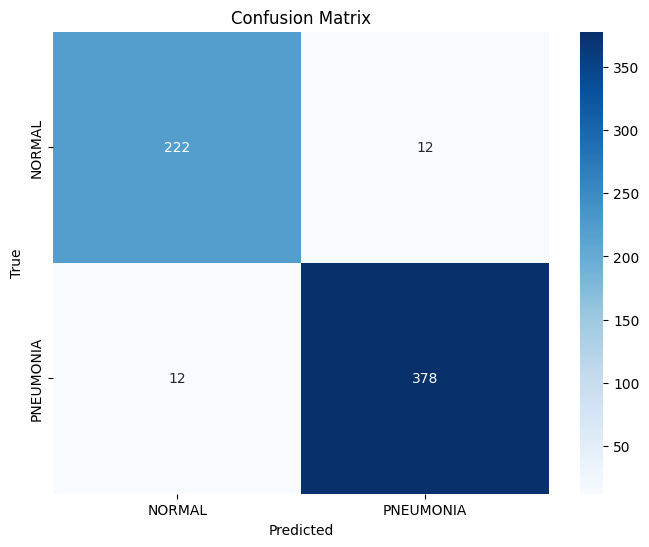


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       234
   PNEUMONIA       0.97      0.97      0.97       390

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



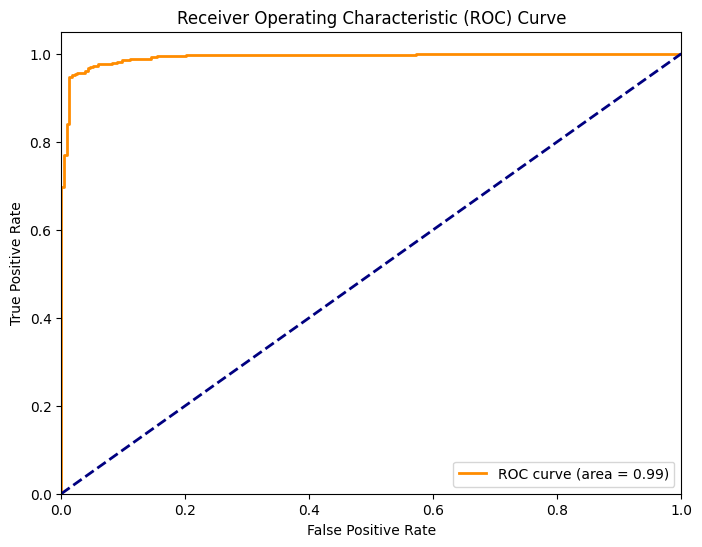

In [48]:
def evaluate_model(model, dataloader, class_names):
    model.eval() # Set model to evaluate mode
    all_labels = []
    all_preds = []
    all_probs = []

    running_corrects = 0
    running_loss = 0.0

    with torch.no_grad():
        # for inputs, labels in tqdm(dataloader, desc="Testing"): # Removed tqdm
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) # Use the same criterion as training

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ROC Curve and AUC
    # If there are only two classes, we can plot a single ROC curve for the positive class
    if len(class_names) == 2:
        # Assuming 'Pneumonia' is the positive class (index 1)
        fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC curve not plotted for multi-class classification.")

# Visualize training history
def plot_training_curves(history, history_finetune=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Combine histories if fine-tuning was performed
    combined_history = {
        'train_loss': history['train_loss'] + (history_finetune['train_loss'] if history_finetune else []),
        'train_acc': history['train_acc'] + (history_finetune['train_acc'] if history_finetune else []),
        'val_loss': history['val_loss'] + (history_finetune['val_loss'] if history_finetune else []),
        'val_acc': history['val_acc'] + (history_finetune['val_acc'] if history_finetune else [])
    }

    # Plot Loss
    axes[0].plot(combined_history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(combined_history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy
    axes[1].plot(combined_history['train_acc'], label='Train Accuracy', marker='o')
    axes[1].plot(combined_history['val_acc'], label='Validation Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training curves before evaluation
plot_training_curves(history, history_finetune)
# Evaluate the model on the test set
evaluate_model(model_ft, dataloaders['test'], class_names)

In [44]:
# Calculate and display overall accuracy and counts
def calculate_accuracy_and_counts(model, dataloader):
    model.eval()
    correct_predictions = 0
    incorrect_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += torch.sum(preds == labels).item()
            incorrect_predictions += torch.sum(preds != labels).item()

    accuracy = correct_predictions / total_samples if total_samples > 0 else 0

    print(f"\nOverall Test Set Evaluation:")
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Incorrect predictions: {incorrect_predictions}")
    print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate and display for the test set
calculate_accuracy_and_counts(model_ft, dataloaders['test'])


Overall Test Set Evaluation:
Total samples: 624
Correct predictions: 600
Incorrect predictions: 24
Overall Accuracy: 0.9615


### Step 9 -  Visualization of Training Prediction


Visualizing correct and incorrect predictions on test set...


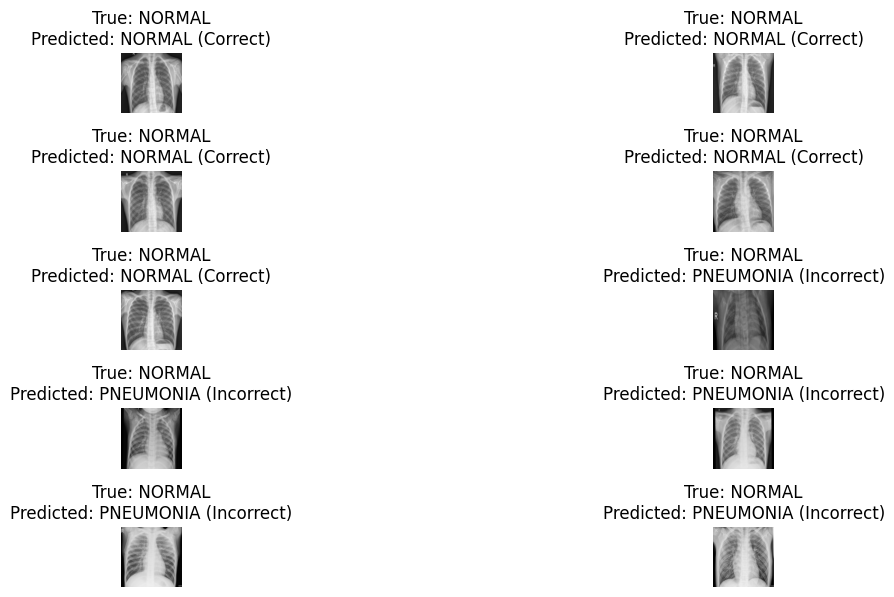

In [43]:
def visualize_predictions(model, dataloader, class_names, num_correct=3, num_incorrect=3):
    model.eval()
    correct_images_so_far = 0
    incorrect_images_so_far = 0
    plt.figure(figsize=(12, 12)) # Increase figure size for more images

    print("\nVisualizing correct and incorrect predictions on test set...")
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if preds[j] == labels[j] and correct_images_so_far < num_correct:
                    correct_images_so_far += 1
                    ax = plt.subplot(num_correct + num_incorrect, 2, correct_images_so_far + incorrect_images_so_far) # Adjusted subplot indexing
                    ax.axis('off')
                    ax.set_title(f'True: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]} (Correct)')

                    # Unnormalize and display the image
                    img = inputs.cpu().data[j]
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std[:, None, None] * img.numpy() + mean[:, None, None]
                    img = np.clip(img, 0, 1)
                    plt.imshow(np.transpose(img, (1, 2, 0)))

                elif preds[j] != labels[j] and incorrect_images_so_far < num_incorrect:
                    incorrect_images_so_far += 1
                    ax = plt.subplot(num_correct + num_incorrect, 2, correct_images_so_far + incorrect_images_so_far) # Adjusted subplot indexing
                    ax.axis('off')
                    ax.set_title(f'True: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]} (Incorrect)')

                    # Unnormalize and display the image
                    img = inputs.cpu().data[j]
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std[:, None, None] * img.numpy() + mean[:, None, None]
                    img = np.clip(img, 0, 1)
                    plt.imshow(np.transpose(img, (1, 2, 0)))

                if correct_images_so_far == num_correct and incorrect_images_so_far == num_incorrect:
                    break

            if correct_images_so_far == num_correct and incorrect_images_so_far == num_incorrect:
                break

        plt.tight_layout()
        plt.show()

# Visualize some correct and incorrect predictions from the test set
visualize_predictions(model_ft, dataloaders['test'], class_names, num_correct=10, num_incorrect=10) # Visualize 5 correct and 5 incorrect examples